# This notebook demonstrates the use of Sparse Component Analysis (SCA) using a center-out reaching dataset

Data are trial-averaged firing rates of individual neurons collected from motor cortex (primary motor and dorsal premotor) of a non-human primate.

For this task, the monkey began each trial by touching a central touch-point. A peripheral target was shown, and after a variable, unpredictable delay period, a go cue was delivered. After capturing the peripheral target, the monkey recieved a juice reward, and returned his hand to the touch-point to begin the next trial (see [Lara et al., 2018](https://pubmed.ncbi.nlm.nih.gov/30132759/))

Data have been aligned to target onset, outward movement onset, and return reach onset.

'data' is a Condition x Neuron x Time tensor of trial-averaged firing rates.


## Import various packages

In [1]:
import numpy as np
from scipy import io

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

from sca.models import SCA, WeightedPCA
from sca.util import get_sample_weights, get_accuracy
from plotly.subplots import make_subplots

/opt/anaconda3/envs/ssa/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## local path to the directory
    - fill in the path to whererever you've saved 'datasets'

In [2]:
# local_path = ## FILL IN PATH ##

local_path = '../datasets/'

## load data

In [3]:
data=io.loadmat(local_path + 'monkeyB_reaching.mat')

# pull out the PSTHs
# data is a C x N x T tensor 
data_array=data['data']

## Preprocess data
We're going to perform two standard (to this dataset) pre-processing steps:

   1. soft-normalize the rates (firing rate range across all conditions and times + 5)
        This step has the effect of preventing the recovered factors from being dominated by a few high firing-rate neurons while also minimizing the impact of very low firing rate neurons

   2. subtract off the cross-condition mean
        The largest signal (in terms of variance) in motor cortex during reaching is a condition-invariant 'trigger signal' (see [Kaufman et al., 2016](https://pubmed.ncbi.nlm.nih.gov/27761519/) for further discussion).
        Because we are often more interested in the condition-specific signals, we typically subtract off this trigger signal.


In [4]:
#Downsample data to speed up SCA (using a factor of 10 here)
data_downsamp=data_array[:,:,np.arange(0,data_array.shape[2],10)]

# pull out some useful numbers
numConds,numN,trlDur = np.shape(data_downsamp)

#Concatenate all the conditions (so the matrix is size N x TC instead of C x N x T)
data_concat=data_downsamp.swapaxes(0,1).reshape([data_downsamp.shape[1],data_downsamp.shape[0]*data_downsamp.shape[2]])

#fr range
fr_range=np.ptp(data_concat,axis=1)[:,None]

# make a time mask
timeMask = np.tile(np.arange(trlDur),(1,numConds)).T.flatten()

# define the times we want to use for sca/pca
# target on: 20
# move on:   77
# return:    200
trainTimes = np.arange(20,230)

# define a 'training mask' for convenience 
trainMask = np.in1d(timeMask,trainTimes)

#Subtract cross-condition mean
data_scm=data_downsamp-np.mean(data_downsamp,axis=0)[None,:,:]

#Concatenate all the conditions (so the matrix is size N x TC instead of C x N x T)
data_scm_concat=data_scm.swapaxes(0,1).reshape([data_scm.shape[1],data_scm.shape[0]*data_scm.shape[2]])

#Soft normalize (divide each neuron by its fr range + 5)
data_scm_norm=data_scm_concat/(fr_range+5)

# rename the data for convenience
#Note that model requires (T x N) input rather than (N x T), which is why there are transposes below
fit_data=np.copy(data_scm_norm.T)

# how much to weight each timestep (used by)
sample_weights=get_sample_weights(fit_data)


## Define some SCA parameters
SCA has three hyperparameters:

   number of requested factors (R_est)
   lam_orthog: determines the degree to which non-orthogonal dimensions are penalized
   lam_sparse: determines the degree to which non-sparse factors are punished.

For this analysis, we are going to use the default values for lam_orthog and lam_sparse.

Across all examined datasets, the recovered SCA factors vary litte across different hyperparameter choices

In [5]:
# number of dimensions to find
R_est=8

## Fit SCA

Using lam_sparse=  0.026215569074801496
Using lam_orthog=  146.9962608098346
Using device cpu


100%|██████████| 3000/3000 [00:07<00:00, 379.98it/s]


SCA R2: 0.6259895797389438


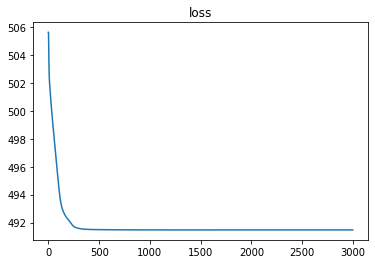

In [6]:
# fit model and 
sca = SCA(n_components=R_est)
sca.fit(X=fit_data[trainMask,:],sample_weight = sample_weights[trainMask])

# project all data into the sca dimensions
sca_latent=sca.transform(fit_data)


# plot loss
plt.plot(sca.losses);
plt.title('loss');

# display fraction of total variance explained by the SCA factors
print('SCA R2: ' + str(sca.r2_score))

In [7]:
# plot the dot product of the learned U weights (which are not constrained to be orthonormal)
U = sca.params['U']
U_dProd = U.T@U

# plot
fig = px.imshow(U_dProd)
fig.update_layout(height = 300, width = 300,title = 'dot product of U')

In [8]:
# plot the dot product of the learned V weights (which are constrained to have a norm of 1, and may or may not be constrained to be orthogonal, depending on the 'orthFlg')
V = sca.params['V']
V_dProd = V@V.T

# plot
fig = px.imshow(abs(V_dProd),range_color = [0,1])
fig.update_layout(height = 300, width = 300,title = 'dot product of V')

### Fit wPCA for comparison
   We're going to use a variant of PCA (weighted PCA), which is a more direct comparison to SCA (they primarily differ in the use of sparsity, rather than also differing due to sample weighting)

   The weighting ensures that low-firing rate time periods are not ignored in favor of high firing-rate periods

In [9]:
#Fit model and project data into the PC space
wpca = WeightedPCA(n_components=R_est)
pca_latent = wpca.fit_transform(X=fit_data[trainMask,:], sample_weight=sample_weights[trainMask])

# get the factor weights
U_pca = wpca.params['U']
V_pca = wpca.params['V']

# calculate reconstruction R2
[pca_r2_score, pca_reconstruction_loss]=get_accuracy(wpca,fit_data[trainMask,:],sample_weights[trainMask])

# display results
print('PCA R2: ' + str(pca_r2_score))

PCA R2: 0.6302325785992451


### Note that SCA and wPCA account for virtually identical amounts of neural variance

### define some plotting colors

In [10]:
cMap  = ['#5e0044', '#6f144e', '#812858', '#933c62', '#a5506d', '#b76477', '#c97881', '#db8c8c']

### Plot factors
order factors by the time of maximum occupancy (cross-condition variance)

In [11]:
# calculate across-condition variance of each projection as a function of time

# reshape both latents to be size T x C x K 
rs_sca_latent = np.reshape(sca_latent,(-1,8,R_est),order = 'F')

# calculate across condition variance
sca_var = np.var(rs_sca_latent,axis = 1)

# find peak occupancy of each dimension
pkIdx = np.argmax(sca_var,axis = 0)

# define plotting order
sca_order = np.argsort(pkIdx)

# resort ssa_latents by time of maximum occupancy
rs_sca_latent = rs_sca_latent[:,:,sca_order]

# do the same for the pca projections
rs_pca_latent = np.reshape(pca_latent,(-1,8,R_est),order = 'F')

pca_var = np.var(rs_pca_latent,axis = 1)
pkIdx = np.argmax(pca_var,axis = 0)
pca_order = np.argsort(pkIdx)
rs_pca_latent = rs_pca_latent[:,:,pca_order]

# define some useful time points
tgt_idx=20
move_idx=77
ret_idx=200


#### SCA
vertical lines mark target onset, outward reach onset, and return reach onset

In [12]:
# range for y axis
yRange = [-1.8,1.8]

fig = make_subplots(rows=R_est,cols = 1,shared_xaxes = True,vertical_spacing = 0)

for ii in range(R_est):

    for jj in range(numConds):
        latTrace = go.Scatter(y = rs_sca_latent[:,jj,ii], line = go.scatter.Line(color = cMap[jj],width = 2.5),showlegend = False)
        fig.add_trace(latTrace,row = ii+1,col=1)

    # mark important task events
    fig.add_vline(x = tgt_idx,row = ii+1,col = 1, line_color = 'black')
    fig.add_vline(x = move_idx,row = ii+1,col = 1, line_color = 'black')
    fig.add_vline(x = ret_idx,row = ii+1,col = 1, line_color = 'black')

    # add a vertical line for scale
    scaleLine = go.Scatter(x = [0,0],y = [-1,1],showlegend = False,mode = 'lines',
                            line = go.scatter.Line(color = 'black',width = 5))
    fig.add_trace(scaleLine,row = ii+1,col = 1)


# clean up
fig.update_layout(height = 2000,width =600,title = 'SCA',title_font_color = 'black',
                  paper_bgcolor = 'white',
                  plot_bgcolor = 'white')
fig.update_yaxes(showgrid = False,zeroline = False,visible = False,range = yRange)
fig.update_xaxes(color = 'black',showgrid = False,zeroline = False,visible = False)
fig.update_xaxes(color = 'black',showgrid = False,zeroline = False,
                 ticks = 'outside',tickvals = [0,50],ticktext = ['0','500'],visible = True,row = R_est,col = 1)

fig.show()

### PCA

In [13]:
# range for y axis
yRange = [-1.8,1.8]

fig = make_subplots(rows=R_est,cols = 1,shared_xaxes = True,vertical_spacing = 0)

for ii in range(R_est):

    for jj in range(numConds):
        latTrace = go.Scatter(y = rs_pca_latent[:,jj,ii], line = go.scatter.Line(color = cMap[jj],width = 2.5),showlegend = False)
        fig.add_trace(latTrace,row = ii+1,col=1)

    # mark important task events
    fig.add_vline(x = tgt_idx,row = ii+1,col = 1, line_color = 'black')
    fig.add_vline(x = move_idx,row = ii+1,col = 1, line_color = 'black')
    fig.add_vline(x = ret_idx,row = ii+1,col = 1, line_color = 'black')

    # add a vertical line for scale
    scaleLine = go.Scatter(x = [0,0],y = [-1,1],showlegend = False,mode = 'lines',
                            line = go.scatter.Line(color = 'black',width = 5))
    fig.add_trace(scaleLine,row = ii+1,col = 1)


# clean up
fig.update_layout(height = 2000,width =600,title = 'PCA',title_font_color = 'black',
                  paper_bgcolor = 'white',
                  plot_bgcolor = 'white')
fig.update_yaxes(showgrid = False,zeroline = False,visible = False,range = yRange)
fig.update_xaxes(color = 'black',showgrid = False,zeroline = False,visible = False)
fig.update_xaxes(color = 'black',showgrid = False,zeroline = False,
                 ticks = 'outside',tickvals = [0,50],ticktext = ['0','500'],visible = True,row = R_est,col = 1)

fig.show()

## Comparisons between SCA and PCA factors
Each SCA factor is primarily active before a reach, during a reach, or during the period when the monkey is holding his had at the peripheral target.

These different patterns of activity correspond to different component computations that generate a reach: preparation, reach execution, and postural maintenance.

Without any supervision, SCA finds factors that reflect the computational division of labor during reaching.

PCA factors, on the other hand, do not show this clean parcellation. Most PCA factors are active during multiple computational epochs.